In [4]:
import os
os.chdir("d:/abhi_project/")
%pwd

'd:\\abhi_project'

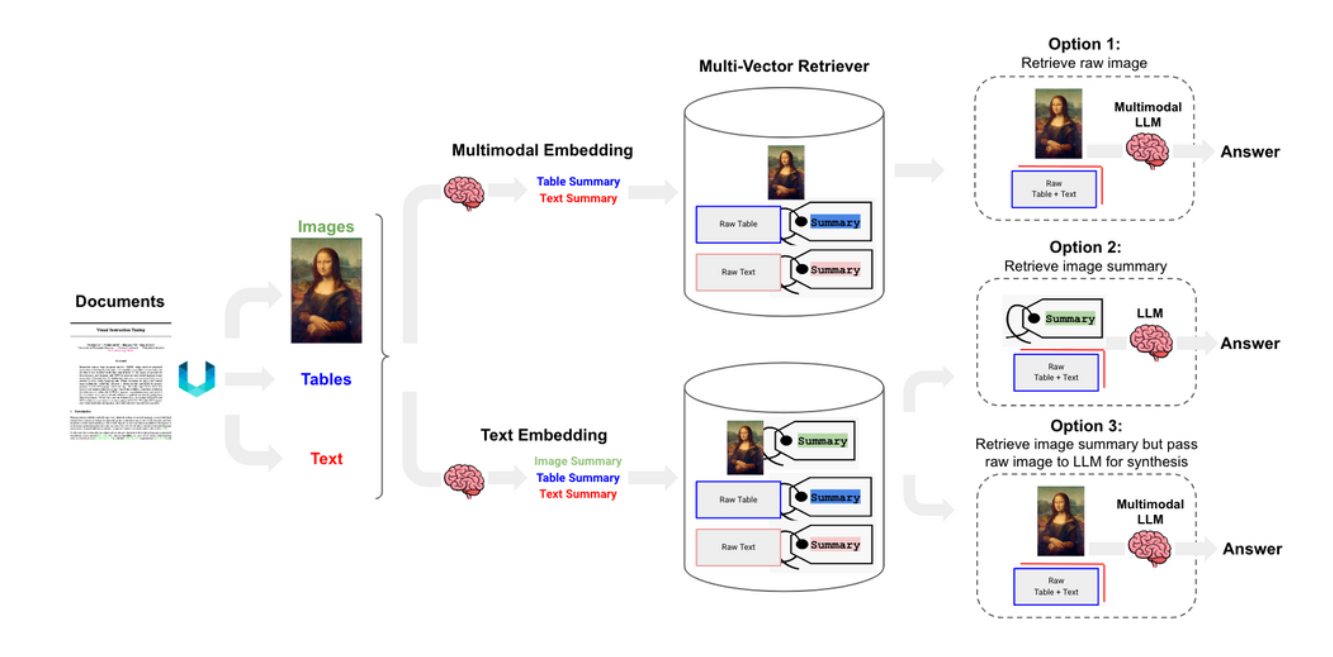

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd


def extract_examination_data():
    """
    Extract titles, publish dates, and PDF links from
    CGU Examination Cell page (last 3 months only)
    """

    url = "https://cgu-odisha.ac.in/examination-cell/"

    response = requests.get(url, timeout=10)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")

    # ✅ Use current system date
    current_date = datetime.now()
    three_months_ago = current_date - timedelta(days=30)

    table = soup.find("table")
    if not table:
        raise ValueError("Examination table not found")

    data = []
    rows = table.find_all("tr")[1:]

    for row in rows:
        cols = row.find_all("td")
        if len(cols) < 4:
            continue

        sl_no = cols[0].get_text(strip=True)
        title = cols[1].get_text(strip=True)
        date_str = cols[2].get_text(strip=True)

        # PDF link
        pdf_link = None
        link_tag = cols[3].find("a")
        if link_tag and link_tag.get("href"):
            pdf_link = link_tag["href"]
            if not pdf_link.startswith("http"):
                pdf_link = f"https://cgu-odisha.ac.in{pdf_link}"

        try:
            notice_date = datetime.strptime(date_str, "%B %d, %Y")
        except ValueError:
            continue

        if notice_date >= three_months_ago:
            data.append({
                "Serial_No": sl_no,
                "Title": title,
                "Publish_Date": date_str,
                "Date_Object": notice_date,
                "PDF_Link": pdf_link if pdf_link else "No PDF available"
            })

    data.sort(key=lambda x: x["Date_Object"], reverse=True)
    return data


In [2]:
records = extract_examination_data()
for r in records:
    print(r)


{'Serial_No': '1', 'Title': 'Award of Degree of Doctor of Philosophy to “2101070007– Sanjay Kumar Jena”', 'Publish_Date': 'December 23, 2025', 'Date_Object': datetime.datetime(2025, 12, 23, 0, 0), 'PDF_Link': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/2101070007.pdf'}
{'Serial_No': '2', 'Title': 'Award of Degree of Doctor of Philosophy to “2101070039– Biswajita Dash”', 'Publish_Date': 'December 23, 2025', 'Date_Object': datetime.datetime(2025, 12, 23, 0, 0), 'PDF_Link': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/2101070039.pdf'}
{'Serial_No': '3', 'Title': 'Award of Degree of Doctor of Philosophy to “2201070020 – Ashutosh Soni”', 'Publish_Date': 'December 23, 2025', 'Date_Object': datetime.datetime(2025, 12, 23, 0, 0), 'PDF_Link': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/2201070020.pdf'}
{'Serial_No': '4', 'Title': 'Award of Degree of Doctor of Philosophy to “19080032– Biswaranjan Swain”', 'Publish_Date': 'December 20, 2025', 'Date_Object': datetime.date

In [3]:
import requests
import base64
from io import BytesIO
from pdf2image import convert_from_bytes

from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, SystemMessage
from langchain_core.documents import Document


In [4]:
def pdf_url_to_images(pdf_url: str):
    response = requests.get(pdf_url, timeout=30)
    response.raise_for_status()

    images = convert_from_bytes(
        response.content,
        dpi=300,
        poppler_path=r"D:\abhi_project\Release-25.12.0-0\poppler-25.12.0\Library\bin"
    )
    return images


In [5]:
def pil_image_to_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


In [6]:
def summarize_page(image_base64, model):
    messages = [
        SystemMessage(
            content=(
                "You are summarizing a scanned academic document page "
                "for a Retrieval-Augmented Generation (RAG) system."
            )
        ),
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": (
                        "Give a detailed, factual summary of this page. "
                        "Extract all dates, rules, tables, headings, and instructions. "
                        "Do not miss any information."
                    )
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        )
    ]

    response = model.invoke(messages)
    return response.content


In [7]:
def build_documents_from_pdfs(records):
    model = init_chat_model("gpt-4o-mini")
    documents = []

    for record in records:
        print(f"Processing PDF: {record['Title']}")

        try:
            images = pdf_url_to_images(record["PDF_Link"])
        except Exception as e:
            print(f"Failed to load PDF: {e}")
            continue

        page_summaries = []

        for i, image in enumerate(images):
            print(f"  Summarizing page {i + 1}/{len(images)}")

            image_base64 = pil_image_to_base64(image)
            page_summary = summarize_page(image_base64, model)

            page_summaries.append(
                f"--- Page {i + 1} ---\n{page_summary}"
            )

        full_summary = "\n\n".join(page_summaries)

        documents.append(
            Document(
                page_content=full_summary,
                metadata={
                    "source": record["Title"],
                    "date": record["Publish_Date"],
                    "pdf_url": record["PDF_Link"]
                },
                id=record["Serial_No"]
            )
        )

    return documents


In [8]:
documents = build_documents_from_pdfs(records)

print(len(documents))
print(documents[0])


Processing PDF: Award of Degree of Doctor of Philosophy to “2101070007– Sanjay Kumar Jena”
  Summarizing page 1/1
Processing PDF: Award of Degree of Doctor of Philosophy to “2101070039– Biswajita Dash”
  Summarizing page 1/1
Processing PDF: Award of Degree of Doctor of Philosophy to “2201070020 – Ashutosh Soni”
  Summarizing page 1/1
Processing PDF: Award of Degree of Doctor of Philosophy to “19080032– Biswaranjan Swain”
  Summarizing page 1/1
Processing PDF: Award of Degree of Doctor of Philosophy to “19080014 – Isha Padhy”
  Summarizing page 1/1
Processing PDF: Award of Degree of Doctor of Philosophy to “20080037– Padmaja Mishra”
  Summarizing page 1/1
Processing PDF: Award of Degree of Doctor of Philosophy to “2101070043 – Surendra Kumar Panda”
  Summarizing page 1/1
Processing PDF: Amendment programme for End Semester Regular Examination of 1st Sem UGPG courses 2025 – 26.
  Summarizing page 1/1
Processing PDF: Programme for End Semester & MID Term Examination of M.Tech – Research c

In [9]:
documents

[Document(id='1', metadata={'source': 'Award of Degree of Doctor of Philosophy to “2101070007– Sanjay Kumar Jena”', 'date': 'December 23, 2025', 'pdf_url': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/2101070007.pdf'}, page_content='--- Page 1 ---\nHere is a detailed summary and extraction of information from the provided document:\n\n---\n\n### Document Summary\n\n**Header Information:**\n- **Institution:** C.V. Raman Global University, Odisha, India\n- **Notification Number:** CGU/CoE/Ph.D/N/031/2025\n- **Date of Notification:** 22/12/2025\n\n**Main Notification:**\n- **Title:** Award of the Degree of Doctor of Philosophy\n- The document states that, based on the recommendation of the Board of Examiners appointed by the Vice-Chancellor, the candidate has been declared qualified for the award of the Ph.D. Degree. This award complies with the provisions of the UGC (Minimum Standards and Procedure for the Award of Ph.D. Degree) Regulation 2022.\n- The degree will be conferred at

In [16]:
print(documents[8])


page_content='--- Page 1 ---
### Summary of Examination Schedule

**Institution**: C.V. Raman Global University, Bhubaneswar  
**Document Title**: Programme for End Semester & MID Term Examination of M.Tech - Research course 2025 - 26  
**Date of Document**: 19.12.2025  
**Exam Format**:  
- **End Semester Examination**:  
  - Time: 10:00 AM to 01:00 PM (1st Sitting)  
- **MID Term Examination**:  
  - Time: 03:00 PM to 04:00 PM (2nd Sitting)  

---

### Examination Dates and Subjects

| Date          | Branch       | Subject with Subject Code                                         |
|---------------|--------------|------------------------------------------------------------------|
| 22.12.2025    | CIVIL        | Sub-Surface Water Engineering - CE649                            |
| 22.12.2025    | CIVIL        | Advanced Structural Analysis - CE612                              |
| 22.12.2025    | EE           | Advance Power System Protection - EE621                          |
| 22.12

In [23]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
exam_vector_store = Chroma(
    embedding_function=embeddings,
    persist_directory='examination_cell_03',
    collection_name='sample'
)

In [24]:
from uuid import uuid4
uuids = [str(uuid4()) for _ in range(len(documents))]

exam_vector_store.add_documents(documents=documents, ids=uuids)

['53bc59c1-fab0-4e39-be34-b557290b9e3a',
 'a9498567-b922-4cd0-b215-e1fbccac2c91',
 '53addaa9-6a73-4ae0-8bc1-8d0fee5f4921',
 '2ee09203-550a-4fc8-898f-5b7735f67449',
 '2d043b60-d79d-4292-b719-b44b277fb804',
 '9e189e05-f0d4-4920-8dd9-3fbd6a34c028',
 '8565c181-1a70-4fda-8e81-9e64ec1ba84c',
 '9bbf92f7-f860-4fce-bdbf-30da97b09e92',
 'a5d0742e-e148-4388-9cd8-cc15d011a432',
 'e0062ca8-bae7-4e2a-b35a-3cebe076cf1e',
 'cf2e3858-2ce1-43ca-95c9-ddb4369b0a9e',
 '3a227613-6ee9-41c5-be5d-76ff2d677dac',
 '0df24ca1-2c1b-45f2-9dc7-8ae6ce795e9d',
 '42c7271d-9e17-4d12-b2db-920d1a87d147',
 '40e15c94-82e7-4284-b896-b1d11ba59d51',
 'fda23454-c963-4722-bc67-3aded5e8949b',
 'c00bbb1c-d7a5-4b74-a6e5-aa79b2823f65',
 '41a43ff7-60b7-4a21-afd8-b6ed5b5a7e24',
 'b4fbce78-87c5-4aed-a39a-843d1662b7f3',
 '9b1d1a24-6ad3-4ffe-9042-6f55c6086963',
 'da36c93a-8db5-4308-97f2-6b88236a0340']

In [25]:
exam_retriever = exam_vector_store.as_retriever(search_type="mmr",
    search_kwargs={
        "k": 4,
        "fetch_k": 20,
        "lambda_mult": 0.5
    })

In [26]:
from pprint import pprint

result = exam_retriever.invoke(
    "Programme for End Semester & MID Term Examination of M.Tech - Research course 2025 - 26"
)

pprint(result)


[Document(id='a5d0742e-e148-4388-9cd8-cc15d011a432', metadata={'date': 'December 19, 2025', 'pdf_url': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/Programme-for-End-Semester-MID-Term-Examination-of-M.Tech-Research-course-2025-26.pdf', 'source': 'Programme for End Semester & MID Term Examination of M.Tech – Research course 2025 – 26.'}, page_content="--- Page 1 ---\n### Summary of Examination Schedule\n\n**Institution**: C.V. Raman Global University, Bhubaneswar  \n**Document Title**: Programme for End Semester & MID Term Examination of M.Tech - Research course 2025 - 26  \n**Date of Document**: 19.12.2025  \n**Exam Format**:  \n- **End Semester Examination**:  \n  - Time: 10:00 AM to 01:00 PM (1st Sitting)  \n- **MID Term Examination**:  \n  - Time: 03:00 PM to 04:00 PM (2nd Sitting)  \n\n---\n\n### Examination Dates and Subjects\n\n| Date          | Branch       | Subject with Subject Code                                         |\n|---------------|--------------|------------

In [27]:
pprint(result[0])


Document(id='a5d0742e-e148-4388-9cd8-cc15d011a432', metadata={'date': 'December 19, 2025', 'pdf_url': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/Programme-for-End-Semester-MID-Term-Examination-of-M.Tech-Research-course-2025-26.pdf', 'source': 'Programme for End Semester & MID Term Examination of M.Tech – Research course 2025 – 26.'}, page_content="--- Page 1 ---\n### Summary of Examination Schedule\n\n**Institution**: C.V. Raman Global University, Bhubaneswar  \n**Document Title**: Programme for End Semester & MID Term Examination of M.Tech - Research course 2025 - 26  \n**Date of Document**: 19.12.2025  \n**Exam Format**:  \n- **End Semester Examination**:  \n  - Time: 10:00 AM to 01:00 PM (1st Sitting)  \n- **MID Term Examination**:  \n  - Time: 03:00 PM to 04:00 PM (2nd Sitting)  \n\n---\n\n### Examination Dates and Subjects\n\n| Date          | Branch       | Subject with Subject Code                                         |\n|---------------|--------------|-------------

In [21]:
exam_retriever = exam_vector_store.as_retriever()

In [22]:
result = exam_retriever.invoke(
    "Programme for End Semester & MID Term Examination of M.Tech - Research course 2025 - 26"
)

pprint(result)

[Document(id='3fcb15a4-66cc-42b9-b815-b3e03becef2e', metadata={'pdf_url': 'https://cgu-odisha.ac.in/wp-content/uploads/2025/12/Programme-for-End-Semester-MID-Term-Examination-of-M.Tech-Research-course-2025-26.pdf', 'source': 'Programme for End Semester & MID Term Examination of M.Tech – Research course 2025 – 26.', 'start_index': 0, 'date': 'December 19, 2025'}, page_content='--- Page 1 ---\n### Summary of Examination Schedule\n\n**Institution**: C.V. Raman Global University, Bhubaneswar  \n**Document Title**: Programme for End Semester & MID Term Examination of M.Tech - Research course 2025 - 26  \n**Date of Document**: 19.12.2025  \n**Exam Format**:  \n- **End Semester Examination**:  \n  - Time: 10:00 AM to 01:00 PM (1st Sitting)  \n- **MID Term Examination**:  \n  - Time: 03:00 PM to 04:00 PM (2nd Sitting)  \n\n---\n\n### Examination Dates and Subjects'),
 Document(id='78ede1d8-3e74-4c76-bc21-fa5633c07357', metadata={'date': 'December 11, 2025', 'start_index': 0, 'pdf_url': 'https: